# TEST NN
In this notebook, we will make some synthetic data and try to recover the underlying model

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import os
home = os.getenv('HOME')
github = home + '/github/DESILSS'
sys.path.append(github)
from NN import read_NNfolds, run_nchainlearning
from split_data import split2Kfolds
import numpy as np
from glob import glob
plt.rc('font', family='serif', size=15)

warning! fitsio is not installed!


## model a multivariate function

will be generating 1000 mock points and do a 3 split


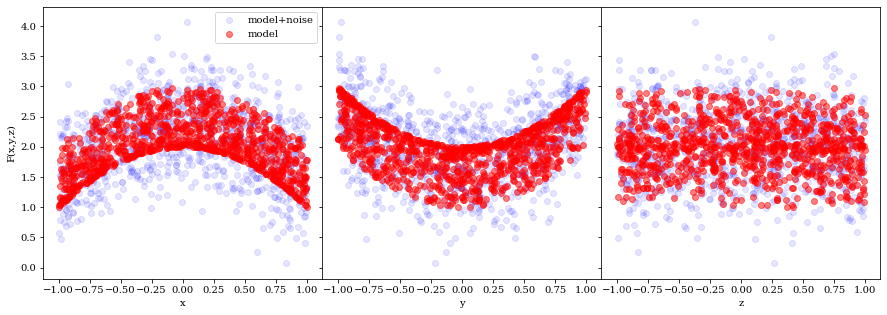

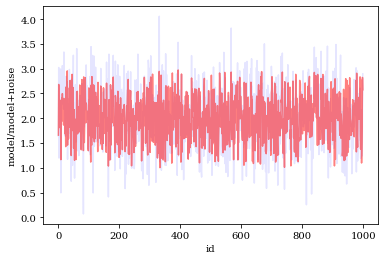

In [2]:
path = github + '/tests/nndata/'
def makemock(n=1000, kfold=3):
    # make mock data
    np.random.seed(1234)
    print('will be generating %d mock points and do a %d split'%(n,kfold))
    F  = lambda x, y, z: (1.+y*y)+(1.-x*x)
    x  = np.random.uniform(-1, 1, size=n)
    y  = np.random.uniform(-1, 1, size=n)
    z  = np.random.uniform(-1, 1, size=n)
    Ft = F(x, y, z)
    noise  = np.std(Ft)*np.random.normal(size=n)
    Fn     = Ft+noise
    #
    # plot the data
    f,a = plt.subplots(ncols=3, sharey=True, figsize=(15,5))
    plt.subplots_adjust(wspace=0.0)
    l = ["x","y","z"]
    for i,s in enumerate([x, y, z]):
        a[i].scatter(s, Fn, alpha=0.1, color='b', label='model+noise')
        a[i].scatter(s, Ft, alpha=0.5, color='r', label='model')
        a[i].set_xlabel(l[i])
    a[0].set_ylabel("F(x,y,z)")
    a[0].legend()
    plt.show()
    plt.figure()
    plt.plot(Fn, alpha=0.1, color='b', label='model+noise')
    plt.plot(Ft, alpha=0.5, color='r', label='model')
    plt.ylabel('model/model+noise')
    plt.xlabel('id')
    plt.show()
    #
    # make a structured array
    data = np.zeros(n, dtype=[('hpix','i8'),
                              ('label','f8'),
                              ('truth', 'f8'),
                              ('features',('f8', 3)),
                              ('error', 'f8'),
                              ('fracgood', 'f8')])
    data['hpix']    = np.arange(n)
    data['label']   = Fn
    data['features']= np.column_stack([x, y, z])
    data['error']   = n
    data['truth']   = Ft
    data['fracgood'] = 1.0
    #
    # bcup for comparisons
    np.save(path + 'NNmock.dat', data)
    #
    # splitdata
    data3fold = split2Kfolds(data, k=kfold)
    np.save(path + 'NN3split.dat', data3fold)
    #
    #
    return data3fold
# 
data3fold = makemock(n=1000)

In [3]:
address = path + 'nnoufiles/'
config = {'nchain':10,
          'nepoch':50,
          'batchsize':50,
          'Units':[20,20,20],
          'learning_rate':0.01,
          'scale':1.e-1}

for rank in [0, 1, 2]:
    fold = 'fold'+str(rank)
    print(fold, ' is being processed')
    run_nchainlearning(address+fold+'/',
                   data3fold['train'][fold],
                   data3fold['validation'][fold], 
                   data3fold['test'][fold],
                  **config)

fold0  is being processed


AttributeError: module 'tensorflow' has no attribute 'set_random_seed'

number of files 3


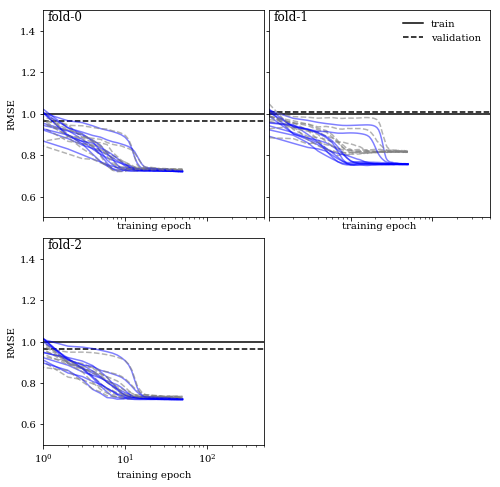

In [17]:
patho   = github + '/tests/nndata/'
address = patho + 'nnoufiles/'
files = glob(address + 'fold*/'+'reg*nepoch50*units202020*scale0.1*')
print('number of files', len(files))
f, ax = plt.subplots(ncols=2, nrows=2, figsize=(8,8), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.02, hspace=0.1)
ax = ax.flatten()
f.delaxes(ax[-1])
for j,file_i in enumerate(files):
    d = np.load(file_i)
    out = d['arr_0'].item()
    for i,mse in enumerate(out['epoch_MSEs']):
        if i == 0:
            ax[j].axhline(np.sqrt(out['options']['baselineMSE'][0]), ls='-', c='k', label='train')
            ax[j].axhline(np.sqrt(out['options']['baselineMSE'][1]), ls='--', c='k', label='validation')

        ax[j].plot(mse[-1][:,0], np.sqrt(mse[-1][:,1]),ls='-',c='blue', alpha=0.5)
        ax[j].plot(mse[-1][:,0], np.sqrt(mse[-1][:,2]),ls='--',c='grey', alpha=0.6)
    ax[j].set_xscale('log')
    ax[j].text(0.02, 0.95, "fold-"+str(j), transform=ax[j].transAxes, fontsize=12)
    if j ==1:ax[j].legend(frameon=False, loc='upper right')
    ax[j].set_ylim(0.5, 1.5)
    if j in [0, 2]:ax[j].set_ylabel('RMSE')
    if j in [2, 3]:ax[j].set_xlabel('Training Epoch')
    ax[j].set_xlim(1, 500)
    ax[j].set_xlabel("training epoch")

In [18]:
# 
from scipy.stats import binned_statistic as bs

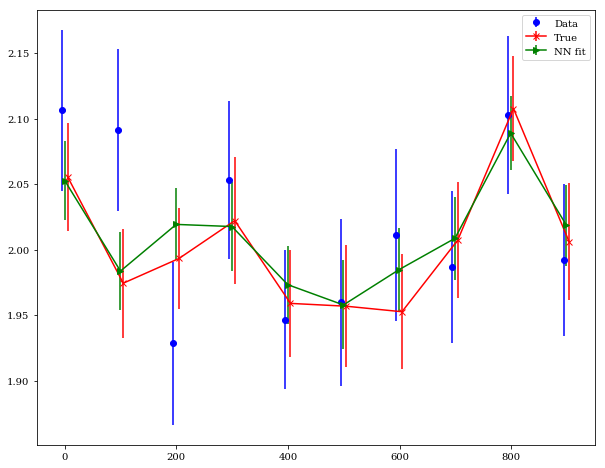

In [19]:
import warnings
warnings.filterwarnings("ignore")

def binscatter(x, y, **kwargs):
    ym, xe,_ = bs(x, y, bins=10)
    std,_,_  = bs(x, y, statistic=np.std, bins=10)
    cnt,_,_  = bs(x, y, statistic='count', bins=10)
    plt.errorbar(xe[:-1], ym, yerr=std/np.sqrt(cnt), **kwargs)

datain = np.load(path + 'NNmock.dat.npy')
P,X,Yt,Yp,_,_ = read_NNfolds(files)

plt.figure(figsize=(10, 8))
binscatter(datain['hpix']-5.0, datain['label'], color='b', label='Data', ls='None', marker='o')
binscatter(datain['hpix']+5.0, datain['truth'], color='r', label='True', marker='x')
binscatter(P, Yp, color='g', label='NN fit', marker='>')
plt.legend()
plt.show()

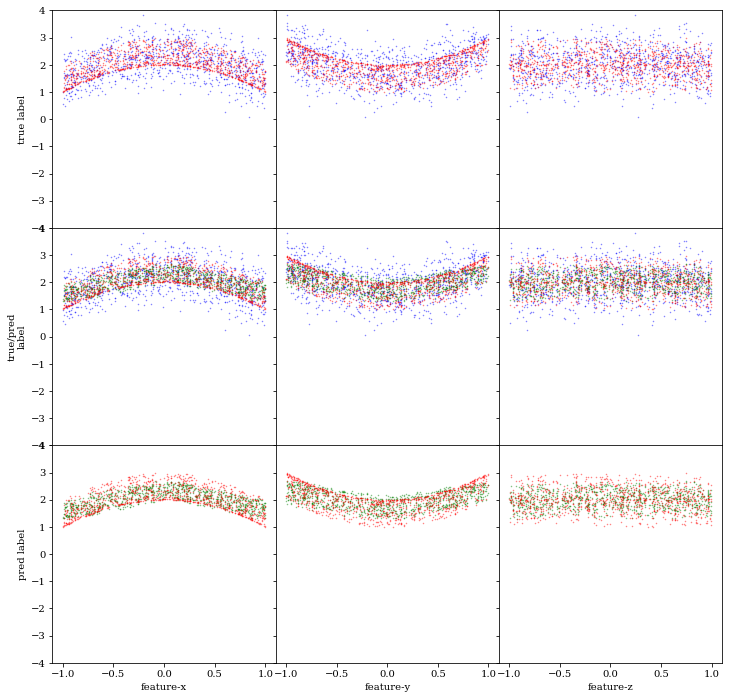

In [20]:
f,a = plt.subplots(ncols=3, nrows=3, figsize=(12,12),
                  sharey=True, sharex=True)
a = a.flatten()
plt.subplots_adjust(wspace=0.0, hspace=0.0)

k = 0
for j in range(3):
    a[0+k].scatter(X[:,j], Yt, 1, marker='.', c='b', alpha=0.5)
    a[6+k].scatter(X[:,j], Yp, 1, marker='.', c='g', alpha=0.5)
    a[3+k].scatter(X[:,j], Yt, 1, marker='.', c='b', alpha=0.5)
    a[3+k].scatter(X[:,j], Yp, 1, marker='.', c='g', alpha=0.5)
    a[0+k].scatter(datain['features'][:,j], datain['truth'], 1, marker='.', c='r', alpha=0.5)
    a[6+k].scatter(datain['features'][:,j], datain['truth'], 1, marker='.', c='r', alpha=0.5)
    a[3+k].scatter(datain['features'][:,j], datain['truth'], 1, marker='.', c='r', alpha=0.5)    
    k += 1

for a_i in a:
    a_i.set_ylim(-4., 4.)
    
l = ['true label', 'true/pred\nlabel', 'pred label']
for j,i in enumerate([0, 3, 6]):
    a[i].set_ylabel(l[j])
l = ['x', 'y', 'z']
for j,i in enumerate([6,7,8]):
    a[i].set_xlabel("feature-"+l[j])

### Model a quadratic function

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import os
home = os.getenv('HOME')
sys.path.append(home + '/github/DESILSS')
import NN
import tensorflow as tf
import numpy as np
from time import time
plt.rc('font', family='serif', size=15)

In [2]:
def prepare_data(X,Y):
    data = np.zeros(X.size, dtype=[('hpix','i8'),
                                  ('fracgood','f8'),
                                  ('label', 'f8'),
                                  ('features', ('f8'))])
    data['features']    = X.copy()
    data['label']       = Y.copy()
    data['fracgood'][:] = 1.0
    return data

We use a NN to fit a set of mock data based on a quadratic function

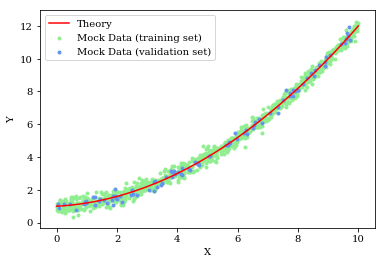

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
chain 0 stopping at 51
took 0.87 secs


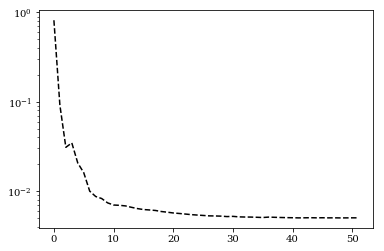

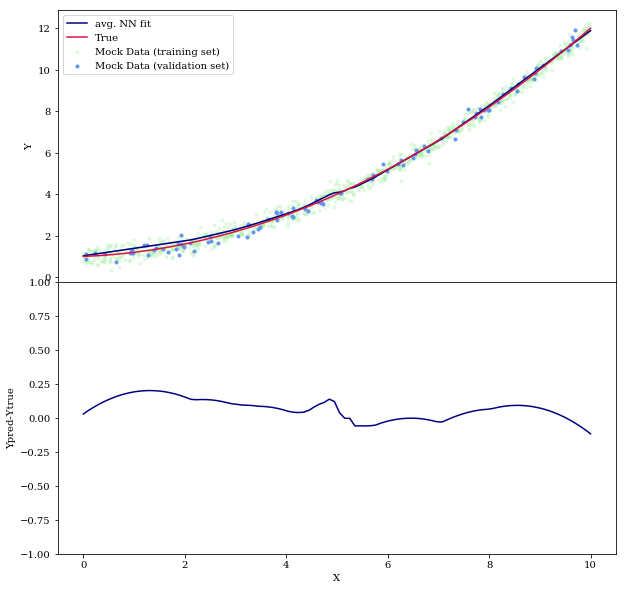

In [7]:
seed  = 12345
np.random.seed(seed)
#func  = lambda x: np.sin(x)
func  = lambda x: 0.1*x**2 + 0.1*x + 1.0
X     = np.random.uniform(0, 10, size=1000) # sort X
Yn    = func(X) *1+ 0.05*np.mean(func(X))*np.random.normal(size=X.size)
xl    = np.linspace(0, 10, 100)
yl    = func(xl)

validm = np.zeros(X.size, '?')
validm[np.random.choice(np.arange(0, X.size), size=X.size//10, replace=False)] = True
Xv, Ynv = X[validm], Yn[validm]
Xt, Ynt = X[~validm], Yn[~validm]

plt.plot(xl, yl, color='r', label='Theory')
plt.scatter(Xt, Ynt, marker='.', color='lightgreen', label='Mock Data (training set)')
plt.scatter(Xv, Ynv, marker='.', color='cornflowerblue', label='Mock Data (validation set)')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
training    = prepare_data(Xt, Ynt)
validation  = prepare_data(Xv, Ynv)
testing     = prepare_data(xl, yl)


t1  = time() # work best for 100,100
net = NN.Netregression(training, validation, testing)
net.train_evaluate(batchsize=100, nchain=1, nepoch=1000, 
                   Units=[100, 100], scale=0.0, tol=1.e-6)

print('took %.2f secs'%(time()-t1))
base_mse    = net.optionsdic['baselineMSE'][1]
meanY, stdY = net.Ystat
meanX, stdX = net.Xstat
for MSE in net.epoch_MSEs:
    plt.plot(MSE[2][:,0], MSE[2][:,2]/base_mse, 'k--')
plt.yscale('log')
plt.show()


fig, ax = plt.subplots(nrows=2, figsize=(10,10), sharex=True)
plt.subplots_adjust(hspace=0)
ax[0].scatter(Xt, Ynt, marker='.', 
              color='lightgreen', label='Mock Data (training set)', alpha=0.2)
ax[0].scatter(Xv, Ynv, marker='.', 
              color='cornflowerblue', label='Mock Data (validation set)')
ymean = []
for l in range(len(net.chain_y)):
    ax[0].plot(stdX*net.test.X.squeeze()+meanX, 
               stdY*net.chain_y[l][1].squeeze()+meanY, 
               color='navy', alpha=0.2)
    ymean.append(stdY*net.chain_y[l][1].squeeze()+meanY)
Ymean = np.mean(ymean, axis=0)
ax[0].plot(stdX*net.test.X.squeeze()+meanX, Ymean, color='navy', label='avg. NN fit')
ax[0].plot(xl, yl, color='crimson', label='True')
ax[1].plot(stdX*net.test.X.squeeze()+meanX, (Ymean-yl), color='navy')
ax[0].legend()
ax[1].set_xlabel('X')
ax[0].set_ylabel('Y')
ax[1].set_ylabel('Ypred-Ytrue')
ax[1].set_ylim(-1., 1.)
plt.show()

reconstruct the sin function, copied from https://stackoverflow.com/a/45197060/9746916

iteration 0, loss=44.967559814453125
iteration 1000, loss=8.723138809204102
iteration 2000, loss=1.9744930267333984
iteration 3000, loss=0.01994793303310871
iteration 4000, loss=0.0077657923102378845
iteration 5000, loss=0.01712718792259693
iteration 6000, loss=0.0052704885601997375
iteration 7000, loss=0.011754541657865047
iteration 8000, loss=0.010276513174176216
iteration 9000, loss=0.006247131619602442


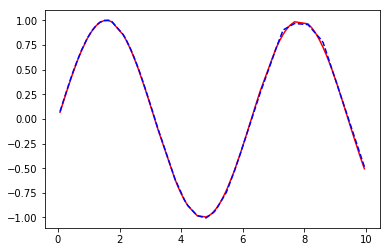

In [4]:
import tensorflow as tf
import numpy as np

with tf.name_scope('placeholders'):
    x = tf.placeholder('float', [None, 1])
    y = tf.placeholder('float', [None, 1])

with tf.name_scope('neural_network'):
    x1 = tf.contrib.layers.fully_connected(x, 100)
    x2 = tf.contrib.layers.fully_connected(x1, 100)
    result = tf.contrib.layers.fully_connected(x2, 1,
                                               activation_fn=None)

    loss = tf.nn.l2_loss(result - y)

with tf.name_scope('optimizer'):
    train_op = tf.train.AdamOptimizer().minimize(loss)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    # Train the network
    for i in range(10000):
        xpts = np.random.rand(100) * 10
        ypts = np.sin(xpts)

        _, loss_result = sess.run([train_op, loss],
                                  feed_dict={x: xpts[:, None],
                                             y: ypts[:, None]})

        if i%1000==0:print('iteration {}, loss={}'.format(i, loss_result))
    xtest = np.sort(np.random.rand(100)*10)
    ypred = sess.run(result, feed_dict={x: xtest[:,None]})

import matplotlib.pyplot as plt
plt.plot(xtest, np.sin(xtest), 'r-')
plt.plot(xtest, ypred, 'b--')
plt.show()

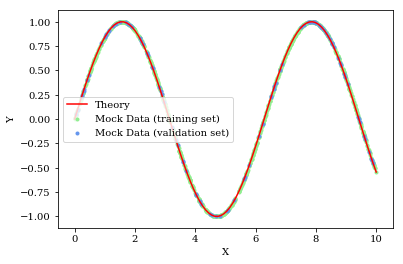

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
chain 0 stopping at 246
took 2.57 secs


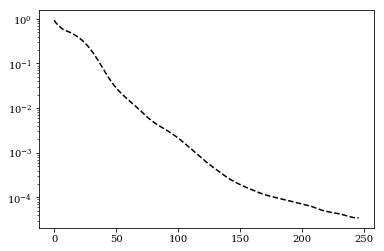

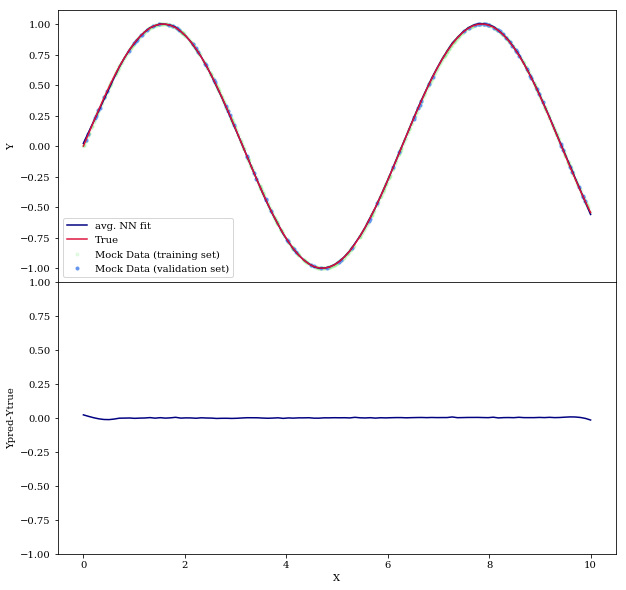

In [11]:
seed  = 12345
np.random.seed(seed)
func  = lambda x: np.sin(x)
# func  = lambda x: 0.1*x**2 + 0.1*x + 1.0
X     = np.random.uniform(0, 10, size=1000) # sort X
Yn    = func(X) #*1+ 1.1*np.mean(func(X))*np.random.normal(size=X.size)
xl    = np.linspace(0, 10, 100)
yl    = func(xl)

validm = np.zeros(X.size, '?')
validm[np.random.choice(np.arange(0, X.size), size=X.size//10, replace=False)] = True
Xv, Ynv = X[validm], Yn[validm]
Xt, Ynt = X[~validm], Yn[~validm]

plt.plot(xl, yl, color='r', label='Theory')
plt.scatter(Xt, Ynt, marker='.', color='lightgreen', label='Mock Data (training set)')
plt.scatter(Xv, Ynv, marker='.', color='cornflowerblue', label='Mock Data (validation set)')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
training    = prepare_data(Xt, Ynt)
validation  = prepare_data(Xv, Ynv)
testing     = prepare_data(xl, yl)


t1  = time() # work best for 100,100
net = NN.Netregression(training, validation, testing)
net.train_evaluate(batchsize=100, nchain=1, nepoch=1000, 
                   Units=[100, 100], scale=0.0, tol=1.e-6)

print('took %.2f secs'%(time()-t1))
base_mse    = net.optionsdic['baselineMSE'][1]
meanY, stdY = net.Ystat
meanX, stdX = net.Xstat
for MSE in net.epoch_MSEs:
    plt.plot(MSE[2][:,0], MSE[2][:,2]/base_mse, 'k--')
plt.yscale('log')
plt.show()


fig, ax = plt.subplots(nrows=2, figsize=(10,10), sharex=True)
plt.subplots_adjust(hspace=0)
ax[0].scatter(Xt, Ynt, marker='.', 
              color='lightgreen', label='Mock Data (training set)', alpha=0.2)
ax[0].scatter(Xv, Ynv, marker='.', 
              color='cornflowerblue', label='Mock Data (validation set)')
ymean = []
for l in range(len(net.chain_y)):
    ax[0].plot(stdX*net.test.X.squeeze()+meanX, 
               stdY*net.chain_y[l][1].squeeze()+meanY, 
               color='navy', alpha=0.2)
    ymean.append(stdY*net.chain_y[l][1].squeeze()+meanY)
Ymean = np.mean(ymean, axis=0)
ax[0].plot(stdX*net.test.X.squeeze()+meanX, Ymean, color='navy', label='avg. NN fit')
ax[0].plot(xl, yl, color='crimson', label='True')
ax[1].plot(stdX*net.test.X.squeeze()+meanX, (Ymean-yl), color='navy')
ax[0].legend()
ax[1].set_xlabel('X')
ax[0].set_ylabel('Y')
ax[1].set_ylabel('Ypred-Ytrue')
ax[1].set_ylim(-1., 1.)
plt.show()